In [2]:
import json
import re
from pathlib import Path
from collections import Counter
import random
import datetime

import pandas as pd
from tqdm import tqdm
import numpy as np

# NLP / ML
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

import umap
import hdbscan
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Highway\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import bitermplus as btm
# from sentence_transformers import SentenceTransformer

## TASK 2.1: Tweet-level data

In [5]:
DATA_DIR = Path("../../")

# --- Read accounts.tsv ---
accounts_path = DATA_DIR / "accounts.tsv"
accounts_df = pd.read_csv(
    accounts_path,
    sep="\t",
    dtype=str,            # keep IDs as strings
    keep_default_na=False # avoid NaN for empty fields
)

# Standardize column names
accounts_df.columns = [c.strip() for c in accounts_df.columns]
if "author_id" not in accounts_df.columns:
    for alt in ["id", "user_id", "account_id"]:
        if alt in accounts_df.columns:
            accounts_df = accounts_df.rename(columns={alt: "author_id"})
            break

print("=== accounts.tsv ===")
print(accounts_df.head())
print(accounts_df["Type"].value_counts())

=== accounts.tsv ===
             author_id                 Type Lang Stance
0              8508262  Private individuals   fr    For
1           3297659759      Advocacy actors   es    For
2  1351436889316683778  Journalistic actors   en    For
3            259352661      Advocacy actors   en    For
4             17158610      Advocacy actors   en    For
Type
Advocacy actors        632
Political actors       310
Journalistic actors    271
Business actors        241
Private individuals    227
Unclear                142
Scientific actors       90
                         9
Other                    9
Bots                     4
to-do                    1
Name: count, dtype: int64


In [6]:
tweets_path = DATA_DIR / "tweets.dat"

def parse_tweets(path, max_rows=None):
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if max_rows and i >= max_rows:
                break
            try:
                obj = json.loads(line)
                rows.append({
                    "id": obj.get("id"),
                    "author_id": obj.get("author_id"),
                    "text": obj.get("text"),
                    "created_at": obj.get("created_at"),
                    "lang": obj.get("lang"),
                    "referenced_tweets": obj.get("referenced_tweets"),
                    "public_metrics": obj.get("public_metrics"),
                })
            except Exception as e:
                # skip malformed lines
                continue
    return pd.DataFrame(rows)

# --- Read tweets.dat ---
tweets_df = parse_tweets(tweets_path, max_rows=None)
print("Parsed tweets:", len(tweets_df))
tweets_df.head()

Parsed tweets: 2260916


,id,author_id,text,created_at,lang,referenced_tweets,public_metrics
0,675827469119832066,1011975294,RT @MinisterTdB: Climate change won’t stop ove...,2015-12-12T23:59:59.000Z,en,"[{'type': 'retweeted', 'id': '6757779674700390...","{'retweet_count': 107, 'reply_count': 0, 'like..."
1,675827469006581760,255144027,RT @LaurenceTubiana: I just can believe it !we...,2015-12-12T23:59:59.000Z,en,"[{'type': 'retweeted', 'id': '6757815547450572...","{'retweet_count': 109, 'reply_count': 0, 'like..."
2,675827468775718912,214748274,RT @COP21en: We did it! #ParisAgreement is ado...,2015-12-12T23:59:59.000Z,en,"[{'type': 'retweeted', 'id': '6757487202442977...","{'retweet_count': 1204, 'reply_count': 0, 'lik..."
3,675827465378504705,449273927,RT @TheGlobalGoals: Incredible news for our wo...,2015-12-12T23:59:58.000Z,en,"[{'type': 'retweeted', 'id': '6757646325990440...","{'retweet_count': 110, 'reply_count': 0, 'like..."
4,675827465336434688,1601937732,RT @StopShenhua: “The people’s resolve is such...,2015-12-12T23:59:58.000Z,en,"[{'type': 'retweeted', 'id': '6757735596884541...","{'retweet_count': 49, 'reply_count': 0, 'like_..."


In [7]:
merged_df = tweets_df.merge(accounts_df, on="author_id", how="inner")

print("=== merged tweets x accounts ===")
print("Total merged rows:", len(merged_df))
merged_df.head()

=== merged tweets x accounts ===
Total merged rows: 161034


,id,author_id,text,created_at,lang,referenced_tweets,public_metrics,Type,Lang,Stance
0,675827426363121664,2350315591,RT @LaurenceTubiana: I just can believe it !we...,2015-12-12T23:59:49.000Z,en,"[{'type': 'retweeted', 'id': '6757815547450572...","{'retweet_count': 109, 'reply_count': 0, 'like...",Political actors,en,For
1,675827386416541696,518918764,"RT @WWFnoticias: HOY, el mundo marcó el princi...",2015-12-12T23:59:39.000Z,es,"[{'type': 'retweeted', 'id': '6757700921230663...","{'retweet_count': 111, 'reply_count': 0, 'like...",Advocacy actors,es,For
2,675827278295777280,314125926,RT @paris_climate: The #Paris agreement means ...,2015-12-12T23:59:14.000Z,en,"[{'type': 'retweeted', 'id': '6756402297395404...","{'retweet_count': 63, 'reply_count': 0, 'like_...",Advocacy actors,en,For
3,675827253540954112,786625296,(La Nouvelle République):#COP21: Un coup de ma...,2015-12-12T23:59:08.000Z,fr,None,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Journalistic actors,fr,Unclear
4,675827250982428673,786625296,(La Provence):#COP21: Un coup de marteau et to...,2015-12-12T23:59:07.000Z,fr,None,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Journalistic actors,fr,Unclear


In [8]:
# 只保留英文推文
merged_en = merged_df[merged_df["lang"] == "en"].copy()
print("English tweets:", len(merged_en))

English tweets: 83685


In [9]:
def is_retweet(ref):
    """
    ref 是从 Twitter JSON 'referenced_tweets' 字段来的:
    - 可能是 None
    - 可能是 list of dicts, 每个 dict 有 type, id
    如果有任何一个 type == 'retweeted'，我们就认为这是转推
    """
    if isinstance(ref, list) and len(ref) > 0:
        return any(r.get("type") == "retweeted" for r in ref)
    return False

merged_en["is_retweet"] = merged_en["referenced_tweets"].apply(is_retweet)

# 去掉转推，只保留“自己发的”内容
merged_nort = merged_en[~merged_en["is_retweet"]].copy()
print("Non-retweet English tweets:", len(merged_nort))

Non-retweet English tweets: 51778


In [10]:
merged_en["is_retweet"].value_counts(normalize=True)

is_retweet
False    0.618725
True     0.381275
Name: proportion, dtype: float64

In [11]:
merged_nort["text_len"] = merged_nort["text"].str.split().str.len()
merged_long = merged_nort[merged_nort["text_len"] >= 5].copy()
print("After removing super-short tweets:", len(merged_long))

merged_long["text_len"].describe()


After removing super-short tweets: 51688


count    51688.000000
mean        15.541751
std          3.734447
min          5.000000
25%         13.000000
50%         16.000000
75%         18.000000
max         32.000000
Name: text_len, dtype: float64

In [12]:
tweet_counts = (
    merged_long
    .groupby("author_id")
    .size()
    .reset_index(name="n_tweets")
    .sort_values("n_tweets", ascending=False)
)

print("Number of authors:", len(tweet_counts))
tweet_counts.head()


Number of authors: 807


,author_id,n_tweets
508,3584633117,1881
309,2469606308,1230
546,389548615,1010
740,77254498,707
54,131079801,638


In [13]:
tweet_counts["n_tweets"].describe()


count     807.000000
mean       64.049566
std       120.383321
min         1.000000
25%         6.000000
50%        26.000000
75%        76.000000
max      1881.000000
Name: n_tweets, dtype: float64

In [14]:
TOP_N = 807  # 根据上面的 describe 调整
top_authors = tweet_counts.head(TOP_N)["author_id"].tolist()
len(top_authors)


807

In [15]:
top_df = merged_long[merged_long["author_id"].isin(top_authors)].copy()
print("Tweets from top authors:", len(top_df))
top_df.head()


Tweets from top authors: 51688


,id,author_id,text,created_at,lang,referenced_tweets,public_metrics,Type,Lang,Stance,is_retweet,text_len
10,675826779831975936,29584150,#COP21: Thank you for saving our #Planet!\nTha...,2015-12-12T23:57:15.000Z,en,None,"{'retweet_count': 1, 'reply_count': 0, 'like_c...",Advocacy actors,en,For,False,17
13,675826279099273216,18290719,Highlights and shortcomings in the latest Pari...,2015-12-12T23:55:15.000Z,en,None,"{'retweet_count': 1, 'reply_count': 0, 'like_c...",Business actors,en,For,False,15
16,675826025679327233,244013273,#Ambassades @FranceinMiami: RT @creativefrance...,2015-12-12T23:54:15.000Z,en,None,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Journalistic actors,fr,Unclear,False,12
21,675825532781658112,330826792,Check out the complete text!\n#COP21: Draft of...,2015-12-12T23:52:17.000Z,en,None,"{'retweet_count': 16, 'reply_count': 0, 'like_...",Journalistic actors,en,Unclear,False,15
23,675825413248167936,38146999,RT @COP21en Historical moment: #ParisAgreement...,2015-12-12T23:51:49.000Z,en,None,"{'retweet_count': 95, 'reply_count': 1, 'like_...",Political actors,en,For,False,10


In [16]:
len(top_df)

51688

In [18]:
for i in top_df:
    print(i)

id
author_id
text
created_at
lang
referenced_tweets
public_metrics
Type
Lang
Stance
is_retweet
text_len


In [24]:
top_df.to_csv('top_authors_tweets.csv', index=False)

In [21]:
top_df['Type'].value_counts()

Type
Advocacy actors        21067
Private individuals     9493
Journalistic actors     7360
Business actors         5725
Political actors        4812
Scientific actors       1782
Unclear                 1136
Bots                     171
Name: count, dtype: int64

## TASK 2.2: Pre-processing

In [92]:
top_df = pd.read_csv('top_authors_tweets.csv')
top_df.head()

,id,author_id,text,created_at,lang,referenced_tweets,public_metrics,Type,Lang,Stance,is_retweet,text_len
0,675826779831975936,29584150,#COP21: Thank you for saving our #Planet!\nTha...,2015-12-12T23:57:15.000Z,en,NaN,"{'retweet_count': 1, 'reply_count': 0, 'like_c...",Advocacy actors,en,For,False,17
1,675826279099273216,18290719,Highlights and shortcomings in the latest Pari...,2015-12-12T23:55:15.000Z,en,NaN,"{'retweet_count': 1, 'reply_count': 0, 'like_c...",Business actors,en,For,False,15
2,675826025679327233,244013273,#Ambassades @FranceinMiami: RT @creativefrance...,2015-12-12T23:54:15.000Z,en,NaN,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Journalistic actors,fr,Unclear,False,12
3,675825532781658112,330826792,Check out the complete text!\n#COP21: Draft of...,2015-12-12T23:52:17.000Z,en,NaN,"{'retweet_count': 16, 'reply_count': 0, 'like_...",Journalistic actors,en,Unclear,False,15
4,675825413248167936,38146999,RT @COP21en Historical moment: #ParisAgreement...,2015-12-12T23:51:49.000Z,en,NaN,"{'retweet_count': 95, 'reply_count': 1, 'like_...",Political actors,en,For,False,10


In [93]:
selected_df = top_df[top_df['Type'].isin(['Political actors', 'Scientific actors'])]
len(selected_df)
selected_df.head()

,id,author_id,text,created_at,lang,referenced_tweets,public_metrics,Type,Lang,Stance,is_retweet,text_len
4,675825413248167936,38146999,RT @COP21en Historical moment: #ParisAgreement...,2015-12-12T23:51:49.000Z,en,NaN,"{'retweet_count': 95, 'reply_count': 1, 'like_...",Political actors,en,For,False,10
18,675822032966299648,15332989,RT johnlundin: #COP21: With Agreement Near Oba...,2015-12-12T23:38:23.000Z,en,NaN,"{'retweet_count': 0, 'reply_count': 1, 'like_c...",Scientific actors,en,For,False,18
24,675821694515326976,584162442,ICLEI welcomes landmark #ParisAgreement of 12 ...,2015-12-12T23:37:02.000Z,en,NaN,"{'retweet_count': 15, 'reply_count': 0, 'like_...",Political actors,en,For,False,10
41,675820021533294592,867351037,#ClimateAgreement reaffirms value of multilate...,2015-12-12T23:30:23.000Z,en,NaN,"{'retweet_count': 10, 'reply_count': 0, 'like_...",Political actors,en,Unclear,False,15
46,675818495326748672,38146999,.@CFigueres: #ParisAgreement confirms irrevers...,2015-12-12T23:24:20.000Z,en,NaN,"{'retweet_count': 147, 'reply_count': 7, 'like...",Political actors,en,For,False,11


In [94]:
shuffled_df = selected_df.sample(frac=1, random_state=42)

# Group by author_id and take the first 200 rows of each group
selected_tweets = shuffled_df.groupby('author_id').head(200)
selected_tweets = selected_tweets.reset_index(drop=True)

print(f"Original number of rows: {len(selected_df)}")
print(f"Number of rows after sampling: {len(selected_tweets)}")
print(selected_tweets['author_id'].value_counts().head())

Original number of rows: 6594
Number of rows after sampling: 6353
author_id
39719681      200
4332050602    200
2482232082    200
38146999      200
584162442     200
Name: count, dtype: int64


- BTM: Heavy Cleaning + Lemmatization, reducing the sparsity of the short-text vocabulary
- BERT: Light Cleaning, allowing the transformer model to leverage contextual nuances that would otherwise be lost through stemming or lemmatization.

In [ ]:
import re
import html
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')


lemmatizer = WordNetLemmatizer()
STOP = set(stopwords.words('english'))
STOP.update(['amp', 'rt', 'via', 'http', 'https', 'us']) 

# normalization regex
url_re = re.compile(r"http\S+|www\.\S+")
mention_re = re.compile(r"@\w+")
non_word_re = re.compile(r"[^a-z0-9#']+") # BTM: only keep words
clean_re = re.compile(r"[^a-zA-Z0-9#',.!?]+") # BERT: keep punctuation, remove special symbols

# ---------------------------------------------------------
# BTM: Heavy Cleaning + Lemmatization
# ---------------------------------------------------------
def preprocess_for_btm(text):
    if not isinstance(text, str): return []
    
    text = html.unescape(text).lower()
    text = url_re.sub(" ", text)
    text = mention_re.sub(" ", text)
    text = non_word_re.sub(" ", text)
    
    tokens = []
    for t in text.split():
        t = t.strip("'")
        if (t not in STOP) and (len(t) > 2) and (not t.isdigit()):
            lemma = lemmatizer.lemmatize(t) 
            tokens.append(lemma)
            
    return tokens

# ---------------------------------------------------------
# BERT: Light Cleaning
# ---------------------------------------------------------
def preprocess_for_bert(text):
    if not isinstance(text, str): return ""
    
    text = html.unescape(text)
    text = url_re.sub("", text)      # remove URL 
    text = mention_re.sub("", text)  # remove @user
    
    # remove extra spaces
    return " ".join(text.split())

selected_tweets['tokens'] = selected_tweets['text'].apply(preprocess_for_btm)
selected_tweets['text_bert'] = selected_tweets['text'].apply(preprocess_for_bert)

# filter out empty data (based on BTM cleaning results, as it is the strictest)
selected_tweets = selected_tweets[selected_tweets['tokens'].map(len) > 0].copy()
selected_tweets['text_btm_str'] = selected_tweets['tokens'].apply(lambda x: " ".join(x))

# check results
print("=== BTM Input (Lemma) ===")
print(selected_tweets['text_btm_str'].head(2))
print("\n=== BERT Input (Raw Context) ===")
print(selected_tweets['text_bert'].head(2))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Highway\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Highway\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


=== BTM Input (Lemma) ===
0    next step bailique community protocol replicat...
1                tree climate resilience rwanda #cop21
Name: text_btm_str, dtype: object

=== BERT Input (Raw Context) ===
0    Next steps for Bailique Community Protocol are...
1    RT : Trees for climate resilience in Rwanda: v...
Name: text_bert, dtype: object


In [96]:
selected_tweets.head()

,id,author_id,text,created_at,lang,referenced_tweets,public_metrics,Type,Lang,Stance,is_retweet,text_len,tokens,text_bert,text_btm_str
0,673879932901187584,39719681,Next steps for Bailique Community Protocol are...,2015-12-07T15:01:10.000Z,en,NaN,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Scientific actors,en,For,False,21,"[next, step, bailique, community, protocol, re...",Next steps for Bailique Community Protocol are...,next step bailique community protocol replicat...
1,671433927899422720,65339733,RT @CGIAR: Trees for climate resilience in Rwa...,2015-11-30T21:01:37.000Z,en,"[{'type': 'replied_to', 'id': '670819727204360...","{'retweet_count': 0, 'reply_count': 0, 'like_c...",Scientific actors,en,For,False,12,"[tree, climate, resilience, rwanda, #cop21]",RT : Trees for climate resilience in Rwanda: v...,tree climate resilience rwanda #cop21
2,672673768322547712,2976338879,#Africa’s voice should have a #global echo! #c...,2015-12-04T07:08:18.000Z,en,NaN,"{'retweet_count': 3, 'reply_count': 0, 'like_c...",Political actors,en,For,False,15,"[#africa, voice, #global, echo, #climatechange...",#Africa’s voice should have a #global echo! #c...,#africa voice #global echo #climatechange #cop...
3,675372225936162816,257516506,7 research+civil society groups did an indepen...,2015-12-11T17:51:01.000Z,en,NaN,"{'retweet_count': 2, 'reply_count': 0, 'like_c...",Scientific actors,en,Unclear,False,15,"[research, civil, society, group, independent,...",7 research+civil society groups did an indepen...,research civil society group independent asses...
4,671748116597489665,39719681,DOWNLOAD: Beyond loans: instruments to ensure ...,2015-12-01T17:50:06.000Z,en,"[{'type': 'replied_to', 'id': '671747346674417...","{'retweet_count': 3, 'reply_count': 1, 'like_c...",Scientific actors,en,For,False,16,"[download, beyond, loan, instrument, ensure, p...",DOWNLOAD: Beyond loans: instruments to ensure ...,download beyond loan instrument ensure poor ac...


## TASK 2.3: LDA, one last time

Starting grid search:
Training LDA: num_topics=5
--> coherence = 0.2402
Training LDA: num_topics=10
--> coherence = 0.3287
Training LDA: num_topics=15
--> coherence = 0.4056
Training LDA: num_topics=20
--> coherence = 0.4030
Training LDA: num_topics=25
--> coherence = 0.4443
Training LDA: num_topics=30
--> coherence = 0.4487
Training LDA: num_topics=35
--> coherence = 0.4633
Training LDA: num_topics=40
--> coherence = 0.4764
Training LDA: num_topics=45
--> coherence = 0.4864
Training LDA: num_topics=50
--> coherence = 0.4833
Training LDA: num_topics=55
--> coherence = 0.4850
Training LDA: num_topics=60
--> coherence = 0.4834
Training LDA: num_topics=65
--> coherence = 0.4792
Training LDA: num_topics=70
--> coherence = 0.4845
Training LDA: num_topics=75
--> coherence = 0.4805
Training LDA: num_topics=80
--> coherence = 0.4644
Training LDA: num_topics=85
--> coherence = 0.4661
Training LDA: num_topics=90
--> coherence = 0.4588
Training LDA: num_topics=95
--> coherence = 0.4529
Training L

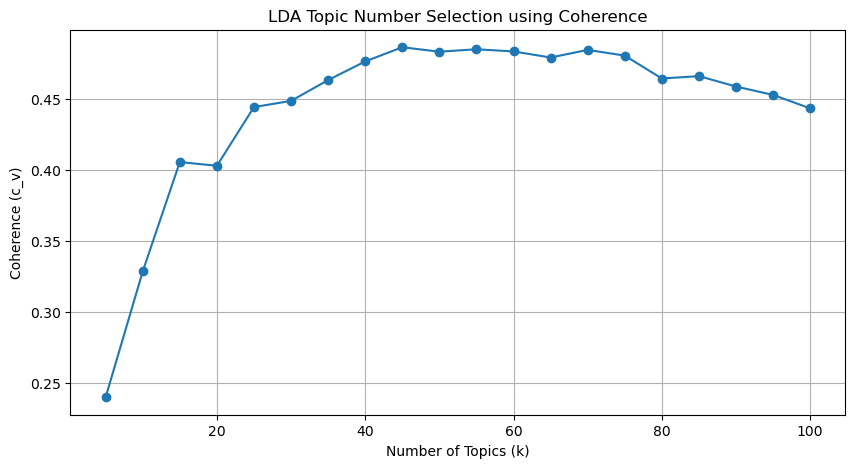

In [ ]:
from gensim.models import LdaModel, CoherenceModel
import matplotlib.pyplot as plt

def search_best_k(dictionary, corpus, texts, min_k=2, max_k=20, step=1):
    coherence_scores = []
    model_list = []

    print("Starting grid search:")

    for k in range(min_k, max_k + 1, step):
        print(f"Training LDA: num_topics={k}")

        lda_model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=k,
            alpha='auto',
            eta='auto',
            random_state=42
        )

        model_list.append(lda_model)

        # coherence
        cm = CoherenceModel(
            model=lda_model,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence = cm.get_coherence()
        coherence_scores.append(coherence)

        print(f"--> coherence = {coherence:.4f}")

    return model_list, coherence_scores


min_k = 5
max_k = 100 
step = 5

docs = selected_tweets['tokens'].tolist()
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in docs]

model_list, coherence_scores = search_best_k(
    dictionary=dictionary,
    corpus=corpus,
    texts=selected_tweets['tokens'].tolist(),
    min_k=min_k,
    max_k=max_k,
    step=step
)

# find best k
best_k = list(range(min_k, max_k + 1, step))[coherence_scores.index(max(coherence_scores))]
print(f"\nBest k based on coherence: {best_k}")


plt.figure(figsize=(10, 5))
plt.plot(range(min_k, max_k + 1, step), coherence_scores, marker='o')
plt.xlabel("Number of Topics (k)")
plt.ylabel("Coherence (c_v)")
plt.title("LDA Topic Number Selection using Coherence")
plt.grid(True)
plt.show()


In [97]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel

docs = selected_tweets['tokens'].tolist()
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in docs]

# LDA
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=30, 
                     alpha='auto', eta='auto', random_state=42)


for idx, topic in lda_model.print_topics(-1):
    print(f"Topic: {idx} \nWords: {topic}")

cm = CoherenceModel(model=lda_model, texts=selected_tweets['tokens'].tolist(), dictionary=dictionary, coherence='c_v')
print("LDA coherence (c_v):", cm.get_coherence())

Topic: 0 
Words: 0.028*"value" + 0.027*"#climatechange" + 0.026*"behind" + 0.025*"nation" + 0.025*"climate" + 0.024*"get" + 0.021*"going" + 0.020*"paris" + 0.020*"together" + 0.019*"engagement"
Topic: 1 
Words: 0.047*"#earthtoparis" + 0.033*"time" + 0.022*"initiative" + 0.021*"climate" + 0.020*"investment" + 0.019*"boost" + 0.019*"option" + 0.018*"action" + 0.018*"society" + 0.017*"civil"
Topic: 2 
Words: 0.055*"climate" + 0.033*"change" + 0.029*"blue" + 0.019*"gap" + 0.019*"#4pacislands" + 0.017*"need" + 0.017*"promoting" + 0.017*"plenary" + 0.016*"forestry" + 0.015*"room"
Topic: 3 
Words: 0.060*"climate" + 0.047*"city" + 0.027*"mayor" + 0.022*"#ycities" + 0.021*"#climatefinance" + 0.020*"addressing" + 0.020*"david" + 0.019*"hope" + 0.019*"action" + 0.019*"role"
Topic: 4 
Words: 0.038*"action" + 0.036*"#lpaa" + 0.035*"government" + 0.032*"climate" + 0.024*"company" + 0.022*"finance" + 0.018*"thank" + 0.018*"problem" + 0.017*"discussion" + 0.017*"scale"
Topic: 5 
Words: 0.070*"climate"

## TASK 2.3: BTM

In [98]:
selected_tweets['tokens']

0       [next, step, bailique, community, protocol, re...
1             [tree, climate, resilience, rwanda, #cop21]
2       [#africa, voice, #global, echo, #climatechange...
3       [research, civil, society, group, independent,...
4       [download, beyond, loan, instrument, ensure, p...
                              ...                        
6348    [#lpaa, press, conference, focus, energy, begi...
6349    [#civilsociety, award, #fossiloftheday, failin...
6350    [common, goal, starting, point, different, cou...
6351    [knowledge, ecosystem, need, included, educati...
6352    [feeling, bit, overwhelmed, #cop21, here's, be...
Name: tokens, Length: 6353, dtype: object

In [99]:
import bitermplus as btm
BTM_K = 30  # number of topics

X, vocabulary, vocab_dict = btm.get_words_freqs(selected_tweets['text_btm_str'].values)
docs_vec = btm.get_vectorized_docs(selected_tweets['text_btm_str'].values, vocabulary)

# Biterms
biterms = btm.get_biterms(docs_vec)

# Train model
model_btm = btm.BTM(X, vocabulary, seed=42, T=BTM_K, M=20, alpha=50/BTM_K, beta=0.01)
model_btm.fit(biterms, iterations=20)

# View results
topics = model_btm.transform(docs_vec)
# Get top words
top_words = btm.get_top_topic_words(model_btm, words_num=10)
print(top_words)

# Store the most likely topic for each tweet
selected_tweets['btm_topic'] = topics.argmax(axis=1)
selected_tweets['btm_topic_prob'] = topics.max(axis=1)

100%|██████████| 6353/6353 [00:00<00:00, 174813.11it/s]

      topic0    topic1    topic2      topic3   topic4    topic5    topic6  \
0  agreement  emission   climate         day     deal     event    carbon   
1    climate      fuel      city     climate    today      side     world   
2      paris    fossil  pavilion        talk    stand     today    energy   
3       need   country      come     country  support       day  emission   
4        new      year      find       event  climate     level   country   
5      draft    energy     learn       video  country      room      need   
6  ambitious     power     booth        role   energy      high      help   
7     global    future    people       watch     core      redd       low   
8       goal   subsidy     water  adaptation     must      poor   climate   
9       deal      need      risk      action     call  observer       say   

      topic7   topic8      topic9  ...   topic20  topic21     topic22  \
0    climate  climate     climate  ...   climate    event      energy   
1     

In [100]:
selected_tweets.head()

,id,author_id,text,created_at,lang,referenced_tweets,public_metrics,Type,Lang,Stance,is_retweet,text_len,tokens,text_bert,text_btm_str,btm_topic,btm_topic_prob
0,673879932901187584,39719681,Next steps for Bailique Community Protocol are...,2015-12-07T15:01:10.000Z,en,NaN,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Scientific actors,en,For,False,21,"[next, step, bailique, community, protocol, re...",Next steps for Bailique Community Protocol are...,next step bailique community protocol replicat...,10,0.695248
1,671433927899422720,65339733,RT @CGIAR: Trees for climate resilience in Rwa...,2015-11-30T21:01:37.000Z,en,"[{'type': 'replied_to', 'id': '670819727204360...","{'retweet_count': 0, 'reply_count': 0, 'like_c...",Scientific actors,en,For,False,12,"[tree, climate, resilience, rwanda, #cop21]",RT : Trees for climate resilience in Rwanda: v...,tree climate resilience rwanda #cop21,14,0.737613
2,672673768322547712,2976338879,#Africa’s voice should have a #global echo! #c...,2015-12-04T07:08:18.000Z,en,NaN,"{'retweet_count': 3, 'reply_count': 0, 'like_c...",Political actors,en,For,False,15,"[#africa, voice, #global, echo, #climatechange...",#Africa’s voice should have a #global echo! #c...,#africa voice #global echo #climatechange #cop...,21,0.629388
3,675372225936162816,257516506,7 research+civil society groups did an indepen...,2015-12-11T17:51:01.000Z,en,NaN,"{'retweet_count': 2, 'reply_count': 0, 'like_c...",Scientific actors,en,Unclear,False,15,"[research, civil, society, group, independent,...",7 research+civil society groups did an indepen...,research civil society group independent asses...,22,0.328187
4,671748116597489665,39719681,DOWNLOAD: Beyond loans: instruments to ensure ...,2015-12-01T17:50:06.000Z,en,"[{'type': 'replied_to', 'id': '671747346674417...","{'retweet_count': 3, 'reply_count': 1, 'like_c...",Scientific actors,en,For,False,16,"[download, beyond, loan, instrument, ensure, p...",DOWNLOAD: Beyond loans: instruments to ensure ...,download beyond loan instrument ensure poor ac...,5,0.333921


In [101]:
selected_tweets.to_csv('selected_tweets_with_btm_topics.csv', index=False)

In [102]:
selected_tweets = pd.read_csv('selected_tweets_with_btm_topics.csv')

Comparing the two methods, BTM outperformed LDA on this short-text dataset.

- Sparsity: LDA struggled with the lack of context in tweets, resulting in topics filled with generic verbs like 'get' or 'going' (e.g., LDA Topic 0).

- Coherence: BTM leveraged global word co-occurrence to find sharper, more semantically connected topics. For instance, while LDA vaguely identified energy terms, BTM specifically clustered 'fossil', 'fuel', and 'subsidy' together (BTM Topic 1), providing a clearer picture of the policy debate.

## TASK 2.4: Embeddings

In [103]:
# Embeddings + Clustering (BERT embeddings -> UMAP -> KMeans)
from sentence_transformers import SentenceTransformer

EMBED_MODEL = 'all-MiniLM-L6-v2'
UMAP_N_COMPONENTS = 5
# HDBSCAN_MIN_CLUSTER_SIZE = 30
KMEANS_N_CLUSTERS = 30
RANDOM_STATE = 42

random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

print("Calculating sentence embeddings...")
embedder = SentenceTransformer(EMBED_MODEL)
embs = embedder.encode(selected_tweets['text_bert'].tolist(), show_progress_bar=True, batch_size=64)

# Dimensionality reduction
print("UMAP dimensionality reduction ...")
umap_model = umap.UMAP(n_components=UMAP_N_COMPONENTS, random_state=RANDOM_STATE)
embs_umap = umap_model.fit_transform(embs)

# print("HDBSCAN clustering ...")
# clusterer = hdbscan.HDBSCAN(min_cluster_size=HDBSCAN_MIN_CLUSTER_SIZE, metric='euclidean', cluster_selection_method='eom')
# cluster_labels = clusterer.fit_predict(embs_umap)
# selected_tweets['embed_cluster'] = cluster_labels

print("KMeans clustering ...")
kmeans = KMeans(n_clusters=KMEANS_N_CLUSTERS, random_state=RANDOM_STATE).fit(embs_umap)
selected_tweets['embed_cluster'] = kmeans.labels_

print("Cluster distribution (including noise -1):")
print(Counter(kmeans.labels_))

Calculating sentence embeddings...


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

UMAP dimensionality reduction ...


c:\Users\Highway\.conda\envs\msd_course\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


KMeans clustering ...
Cluster distribution (including noise -1):
Counter({1: 499, 5: 454, 3: 389, 16: 389, 2: 385, 29: 379, 7: 364, 12: 357, 6: 348, 11: 331, 22: 302, 18: 213, 25: 178, 20: 176, 17: 159, 21: 159, 4: 156, 26: 154, 13: 147, 23: 129, 28: 121, 24: 114, 10: 103, 8: 94, 9: 55, 19: 51, 0: 49, 27: 46, 15: 39, 14: 13})


In [104]:
selected_tweets.head()

,id,author_id,text,created_at,lang,referenced_tweets,public_metrics,Type,Lang,Stance,is_retweet,text_len,tokens,text_bert,text_btm_str,btm_topic,btm_topic_prob,embed_cluster
0,673879932901187584,39719681,Next steps for Bailique Community Protocol are...,2015-12-07T15:01:10.000Z,en,NaN,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",Scientific actors,en,For,False,21,"['next', 'step', 'bailique', 'community', 'pro...",Next steps for Bailique Community Protocol are...,next step bailique community protocol replicat...,10,0.695248,24
1,671433927899422720,65339733,RT @CGIAR: Trees for climate resilience in Rwa...,2015-11-30T21:01:37.000Z,en,"[{'type': 'replied_to', 'id': '670819727204360...","{'retweet_count': 0, 'reply_count': 0, 'like_c...",Scientific actors,en,For,False,12,"['tree', 'climate', 'resilience', 'rwanda', '#...",RT : Trees for climate resilience in Rwanda: v...,tree climate resilience rwanda #cop21,14,0.737613,7
2,672673768322547712,2976338879,#Africa’s voice should have a #global echo! #c...,2015-12-04T07:08:18.000Z,en,NaN,"{'retweet_count': 3, 'reply_count': 0, 'like_c...",Political actors,en,For,False,15,"['#africa', 'voice', '#global', 'echo', '#clim...",#Africa’s voice should have a #global echo! #c...,#africa voice #global echo #climatechange #cop...,21,0.629388,18
3,675372225936162816,257516506,7 research+civil society groups did an indepen...,2015-12-11T17:51:01.000Z,en,NaN,"{'retweet_count': 2, 'reply_count': 0, 'like_c...",Scientific actors,en,Unclear,False,15,"['research', 'civil', 'society', 'group', 'ind...",7 research+civil society groups did an indepen...,research civil society group independent asses...,22,0.328187,25
4,671748116597489665,39719681,DOWNLOAD: Beyond loans: instruments to ensure ...,2015-12-01T17:50:06.000Z,en,"[{'type': 'replied_to', 'id': '671747346674417...","{'retweet_count': 3, 'reply_count': 1, 'like_c...",Scientific actors,en,For,False,16,"['download', 'beyond', 'loan', 'instrument', '...",DOWNLOAD: Beyond loans: instruments to ensure ...,download beyond loan instrument ensure poor ac...,5,0.333921,5


In [105]:
# Comparison
def sample_and_print_from_group(df, col, group_id, n=5):
    sel = df[df[col] == group_id].sample(n=min(n, df[df[col] == group_id].shape[0]), random_state=RANDOM_STATE)
    for _, row in sel.iterrows():
        print("-----")
        print("author:", row['author_id'])
        print(row['text'][:400])
        print()

print("\nTweets of BTM topic 0:")
sample_and_print_from_group(selected_tweets, 'btm_topic', 0, n=5)

print("\nTweets of embedding cluster 13:")
sample_and_print_from_group(selected_tweets, 'embed_cluster', 13, n=5)


Tweets of BTM topic 0:
-----
author: 20646711
We have the means to limit #climatechange: the choice is ours, @IPCC_CH report, read more  https://t.co/8kViwjTIJ8 #COP21

-----
author: 2482232082
For Mats Andersson from #AP4, billions mobilized today are trillions for tomorrow  #LPAA #ActionDay #COP21 https://t.co/ymfiwzoznd

-----
author: 164620984
New dynamics on #COP21: EU + 79 African, Caribbean &amp; Pacific countries for ambitious #climate deal #united4climate https://t.co/KivIFye856

-----
author: 3171055057
#COP21 deal ecourages developing countries to move over time towards economy-wide #emission reduction targets https://t.co/GKWnjcnBDU

-----
author: 21860097
New Draft Agreement #COP21  https://t.co/Uk33HUbh0I


Tweets of embedding cluster 13:
-----
author: 507370446
"90% of extra heat trapped by manmade #globalwarming pollution goes into the ocean" @algore #COP21

-----
author: 2637132063
#US Undersecretary of State at #COP21 Oceans Days: thrilled that US will host the next 

## TASK 2.5: Explanation

Concatenate all tweets in the same cluster into a single unit, then compute a TF-IDF representation of these units, and for each unit (that is, for each cluster) output the top terms based on their TF-IDF score

In [106]:
from sklearn.feature_extraction.text import TfidfVectorizer
def explain_clusters_by_tfidf(df, cluster_col='embed_cluster', top_n=15):
    cluster_texts = df.groupby(cluster_col)['text_btm_str'].apply(lambda s: " ".join(s)).to_dict()
    # filter noise cluster -1
    cluster_texts = {k:v for k,v in cluster_texts.items() if k is not None and k != -1}
    vect = TfidfVectorizer(max_features=20000, ngram_range=(1,2), token_pattern=r"(?u)\b\w+\b")
    docs = [cluster_texts[k] for k in sorted(cluster_texts.keys())]
    tfidf = vect.fit_transform(docs)
    feature_names = np.array(vect.get_feature_names_out())
    top_terms = {}
    for i, k in enumerate(sorted(cluster_texts.keys())):
        row = tfidf[i].toarray().ravel()
        top_idx = row.argsort()[::-1][:top_n]
        top_terms[k] = feature_names[top_idx].tolist()
    return top_terms

In [107]:
print("Explaining embedding clusters (TF-IDF top terms):")
top_terms_clusters = explain_clusters_by_tfidf(selected_tweets, cluster_col='embed_cluster', top_n=15)
for cl, terms in top_terms_clusters.items():
    print(f"Cluster {cl}: {terms}")

Explaining embedding clusters (TF-IDF top terms):
Cluster 0: ['cop21', 'africa', 'renewable', 'energy', 'morocco', 'renewable energy', 'electricity', 'cop21 africa', 'renewables', 'access', 'access electricity', 'global geothermal', 'geothermal', 'cop21 morocco', 'geothermal alliance']
Cluster 1: ['cop21', 'agreement', 'draft', 'text', 'negotiation', 'new', 'agreement cop21', 'ambition', 'progress', 'cop21 agreement', 'must', 'cop21 draft', 'world', 'draft agreement', 'new draft']
Cluster 2: ['cop21', 'paris', 'climate', 'paris climate', 'climatechange', 'climate talk', 'cop21 paris', 'talk', 'paris cop21', 'conference', 'change conference', 'deal', 'cop21 climate', 'climate change', 'climateaction']
Cluster 3: ['cop21', 'city', 'region pavilion', 'mayor', 'cities4climate', 'city region', 'pavilion', 'climate', 'c40', 'region', 'tap2015', 'cop21 city', 'ycities', 'pavilion cop21', 'compactofmayors']
Cluster 4: ['moon', 'ban moon', 'ban', 'cop21', 'moon cop21', 'cop21 ban', 'unsg ban', 

In [108]:
print("Explaining BTM topics (TF-IDF):")
top_terms_btm = explain_clusters_by_tfidf(selected_tweets, cluster_col='btm_topic', top_n=15)
for cl, terms in top_terms_btm.items():
    print(f"BTM Topic {cl}: {terms}")

Explaining BTM topics (TF-IDF):
BTM Topic 0: ['cop21', 'climatechange', 'climate', 'agreement', 'draft', 'line', 'red', 'paris', 'new', 'ambitious', 'red line', 'step', 'reduction', 'need', 'term']
BTM Topic 1: ['cop21', 'fossil', 'fossil fuel', 'fuel', 'fuel subsidy', 'subsidy', 'nuclear power', 'climatechange', 'nuclear', 'emission', 'power', 'car', 'pollution', 'energy', 'year']
BTM Topic 2: ['cop21', 'climatechange', 'booth', 'climate', 'abt climatechange', 'come booth', 'necessary', 'abt', 'learn', 'voice', 'thank', 'come', 'impact', 'eduday', 'visit']
BTM Topic 3: ['cop21', 'climatechange', 'climate', 'start', 'day', 'round', 'watch', 'ldc', 'palau', 'optimism', 'poverty', 'hunger', 's', 'poverty hunger', 'vlog']
BTM Topic 4: ['cop21', 'pls', 'stand', 'humanrights core', 'pls stand', 'core', 'stand today', 'deal', 'champion humanrights', 'core climatechange', 'deal cop21', 'climatechange deal', 'champion', 'call champion', 'today call']
BTM Topic 5: ['cop21', 'event', 'side', 'si

In [ ]:
print("\nTweets of BTM topic 0:")
sample_and_print_from_group(selected_tweets, 'btm_topic', 0, n=5)

print("\nTweets of embedding cluster 13:")
sample_and_print_from_group(selected_tweets, 'embed_cluster', 13, n=5)

Analysis:

- BTM: We found that BTM is very good at identifying broad themes and arguments.

    For example, Topic 1 clearly groups 'fossil fuel', 'subsidy', and 'nuclear'. This represents the Energy Policy debate.

    Topic 4 groups 'human rights', 'stand', and 'champion'. It captures the Activist narrative.

- BERT (Embeddings): However, BERT provided a different perspective. It seems to pinpoint specific actors and events better than BTM.

    For instance, Cluster 9 isolated the 'Rwanda Delegation'.

    Cluster 4 is entirely about 'Ban Ki-moon' (the UN leader).

    BERT separated these specific 'entities' into their own groups, whereas BTM might have just mixed them into general climate discussion.

### Political v.s. Scientific

#### embed_cluster

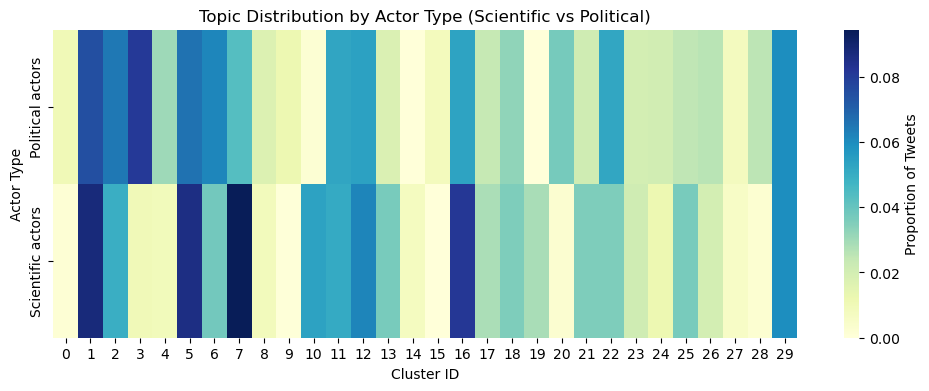

=== Top Scientific Clusters (Scientists tweet more here) ===
embed_cluster
10    0.051821
7     0.051180
16    0.028388
dtype: float64

=== Top Political Clusters (Politicians tweet more here) ===
embed_cluster
3    -0.071056
20   -0.034273
6    -0.023480
dtype: float64


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

crosstab = pd.crosstab(selected_tweets['Type'], selected_tweets['embed_cluster'], normalize='index')

# heatmap
plt.figure(figsize=(12, 4))
sns.heatmap(crosstab, annot=False, cmap="YlGnBu", cbar_kws={'label': 'Proportion of Tweets'})
plt.title('Topic Distribution by Actor Type (Scientific vs Political)')
plt.ylabel('Actor Type')
plt.xlabel('Cluster ID')
plt.show()

# Find the difference between Scientific actors and Political actors
diff = crosstab.loc['Scientific actors'] - crosstab.loc['Political actors']


print("=== Top Scientific Clusters (Scientists tweet more here) ===")
print(diff.sort_values(ascending=False).head(3))

print("\n=== Top Political Clusters (Politicians tweet more here) ===")
print(diff.sort_values(ascending=True).head(3))

In [115]:
print("\nTweets of embedding cluster 1:")
sample_and_print_from_group(selected_tweets, 'embed_cluster', 1, n=3)

print("\nTweets of embedding cluster 3:")
sample_and_print_from_group(selected_tweets, 'embed_cluster', 3, n=3)


Tweets of embedding cluster 1:
-----
author: 2617471956
.@CFigueres "now we need to bring the world together for actions" #COP21 https://t.co/zVtlOPWgGq

-----
author: 2656738964
What is the role of #humanmobility at #COP21 ? Find out at @nanseninitiativ Side Event in room 4 tonight @ 6:30! https://t.co/2owAuFPE3g

-----
author: 588144925
Now @nrg4SD Members exchanging activities, initiatives and thoughts. #COP21 https://t.co/GAvy0tUf9d


Tweets of embedding cluster 3:
-----
author: 18173885
"Local authorities are adapting to climate change" F. Boissier @ademe at 5PM in the Blue Zone #Bourget #COP21 https://t.co/2qz66T3pZX

-----
author: 584162442
Still time to catch some of @EU_GreenCapital debate at Cities &amp; Regions Pavilion, Zone B at #COP21 https://t.co/RFLNxz4Iny

-----
author: 584162442
Tomorrow: @OECD &amp; @giz_gmbh session at 11.45 on disaster &amp; risks in Asian cities - #COP21, Cities &amp; Regions Pavilion, Green Zone B - join us



#### btm_topic

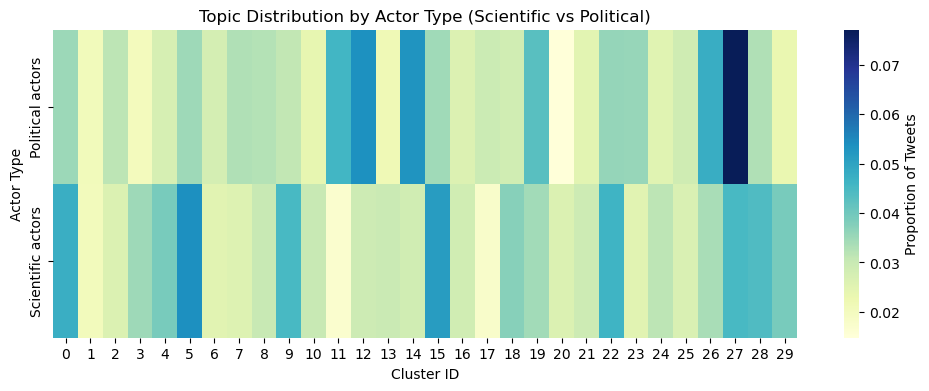

=== Top Scientific Clusters (Scientists tweet more here) ===
btm_topic
5     0.018814
15    0.016960
29    0.015666
dtype: float64

=== Top Political Clusters (Politicians tweet more here) ===
btm_topic
27   -0.031896
11   -0.028657
14   -0.024599
dtype: float64


In [ ]:
crosstab = pd.crosstab(selected_tweets['Type'], selected_tweets['btm_topic'], normalize='index')

plt.figure(figsize=(12, 4))
sns.heatmap(crosstab, annot=False, cmap="YlGnBu", cbar_kws={'label': 'Proportion of Tweets'})
plt.title('Topic Distribution by Actor Type (Scientific vs Political)')
plt.ylabel('Actor Type')
plt.xlabel('Cluster ID')
plt.show()

diff = crosstab.loc['Scientific actors'] - crosstab.loc['Political actors']

print("=== Top Scientific Clusters (Scientists tweet more here) ===")
print(diff.sort_values(ascending=False).head(3))

print("\n=== Top Political Clusters (Politicians tweet more here) ===")
print(diff.sort_values(ascending=True).head(3))

In [117]:
print("\nTweets of BTM topic 27:")
sample_and_print_from_group(selected_tweets, 'btm_topic', 27, n=5)


Tweets of BTM topic 27:
-----
author: 588144925
#RegionsAdapt at @ClimateOutreach Online. #COP21 #Regions4Climate @nrg4sd &amp; @ClimateGroup. Read more: Pag.12 https://t.co/LTwoEHO8KA

-----
author: 140252240
Go behind the scenes with Canada's chief climate negotiator, @environmentca's Louise Metivier: https://t.co/iNCVJR3lzt #COP21

-----
author: 39719681
We're at @TheCVF press conference starting in five mins. Will be talking about the #1o5C target #COP21 https://t.co/KfAeAxalI4

-----
author: 2913017872
Absolutely! We'll continue to keep updating, so stay tuned! #COP21 #COP21Paris #UofMCOP21  https://t.co/UFQ6Dw5U6V

-----
author: 82609758
#COP21 starts today in Paris! 5 facts that help you to 'get' #ClimateChange: https://t.co/Lzvygte7lj



In [119]:
selected_tweets.to_csv('part2_results.csv', index=False)